In [87]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import random
from graphviz import Digraph

In [102]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
            
        out._backward = _backward
        
        return out
    
    def __rmul__(self, other):
        return self * other
    
    def __radd__(self, other):
        return self + other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self * -1
    
    def __sub__(self, other):
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
            
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        
        for node in reversed(topo):
            node._backward()
        

In [82]:
def trace(root):
    
    nodes, edges = set(), set()
    
    def build(v):
        
        if v not in nodes:
            nodes.add(v)
            
            for child in v._prev:
                edges.add((child, v))
                build(child)
                
    build(root)
    return nodes, edges

def draw_dot(root):
    
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot
        

In [77]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')

# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

# bias of neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# o = n.tanh()
e = (2*n).exp()
o = (e - 1) / (e + 1)

o.label = 'o'

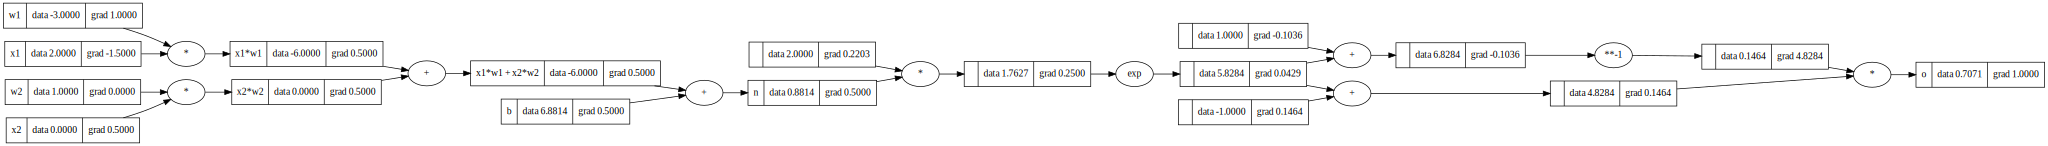

In [78]:
o.backward()
draw_dot(o)

In [109]:
class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # w * x + b
        activation = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = activation.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        

In [110]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.5796681868025457)

In [99]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]

[Value(data=0.8050296814883658),
 Value(data=-0.21726609725343962),
 Value(data=-0.39079150781871214),
 Value(data=0.8092361104495243)]

In [112]:
for k in range(20):
    
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

    # backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    for p in n.parameters():
        p.data += -0.1 * p.grad
    
    print(k, loss.data)

0 6.142246983648731
1 4.047570423628298
2 4.472921096230361
3 5.285470478859501
4 3.2288835312359727
5 4.385637826317599
6 3.1980209346508515
7 3.8645471510554166
8 0.6529539745505997
9 0.19681462698351343
10 0.11392164181438201
11 0.09228223567682438
12 0.07824723253751845
13 0.06788663620936655
14 0.05985648259122174
15 0.05344579452808287
16 0.04821432444251764
17 0.04386912648390943
18 0.0402065638339703
19 0.037080500266028944


In [113]:
ypred

[Value(data=0.9123766012296923),
 Value(data=-0.8642917371055444),
 Value(data=-0.9742805683926955),
 Value(data=0.8983908543784808)]

In [114]:
n.parameters()

[Value(data=-0.8069160561478133),
 Value(data=0.5641431950371005),
 Value(data=1.6140628105256973),
 Value(data=-0.3530519694664346),
 Value(data=-0.5407669576319454),
 Value(data=0.8038521000701305),
 Value(data=-0.4930852807681699),
 Value(data=0.5148059564681604),
 Value(data=-0.6922942700297905),
 Value(data=-0.4497409102993649),
 Value(data=0.28578462281285755),
 Value(data=-0.662104910842521),
 Value(data=1.0290781982279964),
 Value(data=0.43771590150604284),
 Value(data=0.7748122933485542),
 Value(data=0.8347009532630059),
 Value(data=0.9093985967616661),
 Value(data=-1.2261779388871146),
 Value(data=-0.7075139621879296),
 Value(data=-0.5017790994646607),
 Value(data=0.6209111420423764),
 Value(data=-1.1798558575877973),
 Value(data=0.11550929283989951),
 Value(data=0.016325560042807913),
 Value(data=-0.21423406769981812),
 Value(data=0.1834832702918117),
 Value(data=-0.5941227572193322),
 Value(data=0.856981907712624),
 Value(data=0.8391640462768107),
 Value(data=-0.16342240732